In [1]:
import torch
from torch import optim
from tqdm import tqdm
# Imports for this repository
from gmm_data_generator import load_db
from numpy_dataset import NumpyDataset
import torch.nn as nn
import torchvision.transforms as transforms
import numpy as np
from random import choices
from matplotlib import pyplot as plt

In [2]:
PARAMS = {'batch_size': 512,
          'zdim': 2,
          'gamma':0.5,
          'beta1':0.5,
          'beta2':0.999,
          'epochs':20,
          'lr_d': 1e-3,
          'lr_g': 1e-3,
          'epsilon': 1e-8,  # for avoiding numerical instabilities
          'samp_num_gen': 2500}

In [3]:
training_data = load_db()
train_dataset = NumpyDataset(training_data)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=PARAMS['batch_size'],
                                           shuffle=True)

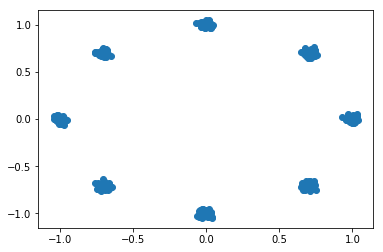

In [4]:
from matplotlib import pyplot as plt

plt.plot(training_data[:, 0], training_data[:, 1], 'o',label='real data')
plt.show()

In [5]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(PARAMS['zdim'], 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, 2),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), 2)
        return img

    def save(self, name):
        torch.save(self.model.state_dict(), name)

    def load(self):
        self.model.load_state_dict(torch.load("./checkpoints/generator_0"))


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(2, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)

        return validity

    def save(self, name):
        torch.save(self.model.state_dict(), name)

    def load(self):
        self.model.load_state_dict(torch.load("./checkpoints/discriminator_0"))


def sample_from_distribution(distribution):
    return Categorical(distribution).sample(sample_shape=torch.Size)


In [6]:
def generator_oracle(data, generator, discriminator, d_dist, discriminator_list, epoch):
    Tensor = torch.FloatTensor
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    valid = Tensor(data.size(0), 1).fill_(1.0).requires_grad_(False).to(device)
    optimizer_G = torch.optim.Adam(generator.parameters(), lr=PARAMS['lr_g'], betas=(PARAMS['beta1'], PARAMS['beta2']))
    
    for d_index in range(len(d_dist)):
        if epoch >= 5 and epoch % 5 == d_index:
            continue
        if d_dist[d_index] == 0:
            continue
        z = Tensor(np.random.normal(0, 1, (data.shape[0], PARAMS['zdim']))).to(device)
        gen_imgs = generator(z).to(device)
        optimizer_G.zero_grad()
        D = discriminator_list[d_index].cuda()
        iterations = 5
        if iterations > 0:
            torch.save(D.model.state_dict(), "backup.pth")
            for i in range(unrolled_steps):
                train_generator_with_sampled_discriminator(generator, D, data, z)
        d_res = D(gen_imgs).to(device)
        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(d_res, valid).to(device)  #*0.5 * d_dist[d_index] 
        g_loss.backward()
        optimizer_G.step()
        if iteration > 0:
            D.model.load_state_dict(torch.load("backup.pth"))
                                                                     
    optimizer_G.zero_grad()
    z = Tensor(np.random.normal(0, 1, (data.shape[0], PARAMS['zdim']))).to(device)
    gen_imgs = generator(z).to(device)
    d_res = discriminator(gen_imgs).to(device) 
    # Loss measures generator's ability to fool the discriminator
    g_loss = adversarial_loss(d_res, valid).to(device) #* 0.5  # * discriminator_distribution[d_index]
    g_loss.backward()
    optimizer_G.step()
    if unrolled_steps > 0:
        discriminator.model.load_state_dict(torch.load("backup.pth"))
    return generator

def discriminator_oracle(data, generator, discriminator, g_dist, generator_list, epoch):
    Tensor = torch.FloatTensor
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    optimizer_TD = torch.optim.Adam(discriminator.parameters(), lr=PARAMS['lr_g'], betas=(PARAMS['beta1'], PARAMS['beta2']))
    
    valid = Tensor(data.size(0), 1).fill_(1.0).requires_grad_(False).to(device)
    fake = Tensor(data.size(0), 1).fill_(0.0).requires_grad_(False).to(device)
    
    real_imgs = data.clone().detach().to(device)
    
    optimizer_TD.zero_grad()
    for g in range(len(g_dist)):
        if epoch > 5 and g == epoch % 5:
            continue
#         if g_dist[g] == 0:
#             continue
        G = generator_list[g].cuda()
        z = Tensor(np.random.normal(0, 1, (data.shape[0], PARAMS['zdim']))).to(device)
        gen_imgs = G(z).to(device)
        real_loss = adversarial_loss(discriminator(real_imgs).to(device), valid)
        # Measure discriminator's ability to classify real from generated samples
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()).to(device), fake) 
        d_loss = (real_loss + fake_loss) #* g_dist[g] * 0.5
        d_loss.backward()
        optimizer_TD.step()
    
    z = Tensor(np.random.normal(0, 1, (data.shape[0], PARAMS['zdim']))).to(device)
    gen_imgs = generator(z).to(device)
    real_loss = adversarial_loss(discriminator(real_imgs).to(device), valid)
    # Measure discriminator's ability to classify real from generated samples
    fake_loss = adversarial_loss(discriminator(gen_imgs.detach()).to(device), fake) 
    d_loss = (real_loss + fake_loss) #* 0.5
    d_loss.backward()
    optimizer_TD.step()
    return discriminator

def train_generator_with_sampled_discriminator(generator, discriminator, imgs, d_gen_input=None):
    optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=PARAMS['lr_d'], betas=(PARAMS['beta1'], PARAMS['beta2']))
    # Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
    Tensor = torch.FloatTensor
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    optimizer_D.zero_grad()
    real_imgs = imgs.clone().detach().to(device)
    valid = Tensor(imgs.size(0), 1).fill_(1.0).requires_grad_(False).to(device)
    fake = Tensor(imgs.size(0), 1).fill_(0.0).requires_grad_(False).to(device)

    # Measure discriminator's ability to classify real from generated samples
    real_loss = adversarial_loss(discriminator(real_imgs).to(device), valid)
    if d_gen_input is None:
        # Sample noise as generator input
        d_gen_input = Tensor(np.random.normal(0, 1, (imgs.shape[0], opt.latent_dim))).to(device)
        # Generate a batch of images
    gen_imgs = generator(d_gen_input).to(device)
    fake_loss = adversarial_loss(discriminator(gen_imgs.detach()).to(device), fake)
    d_loss = (real_loss + fake_loss) / 2
    d_loss.backward()
    optimizer_D.step()

In [7]:
adversarial_loss = torch.nn.BCELoss().cuda()

In [8]:
def calculate_payoff(G,D):
    Tensor = torch.FloatTensor
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    G.cuda()
    D.cuda()
    for i in train_loader:
        valid = Tensor(PARAMS['batch_size'], 1).fill_(1.0).requires_grad_(False).to(device)
        fake = Tensor(PARAMS['batch_size'], 1).fill_(0.0).requires_grad_(False).to(device)

        real_imgs = i.clone().detach().to(device)
        
        
        z = Tensor(np.random.normal(0, 1, (PARAMS['batch_size'], PARAMS['zdim']))).to(device)
        gen_imgs = G(z).to(device)
        
        real_loss = adversarial_loss(D(real_imgs).to(device), valid)
        # Measure discriminator's ability to classify real from generated samples
        fake_loss = adversarial_loss(D(gen_imgs.detach()).to(device), valid) 
        d_loss = (real_loss - fake_loss).detach().cpu().clone()
        
        g_loss = adversarial_loss(D(gen_imgs.detach()).to(device), valid).detach().cpu().clone()
        break
    return d_loss

In [9]:
generator = Generator().cuda()
discriminator = Discriminator().cuda()
calculate_payoff(generator, discriminator)

tensor(-0.0069)

In [10]:
def augment_calculate_missing_entries(meta_matrix, generator_list, discriminator_list):
    meta_matrix = np.zeros((len(generator_list), len(discriminator_list)))
    for i in range(len(generator_list)):
        for j in range(len(discriminator_list)):
            meta_matrix[i][j] = calculate_payoff(generator_list[i], discriminator_list[j])
    return meta_matrix
#     if len(generator_list)==1 and len(discriminator_list)==1:
#         meta_matrix[0][0] = calculate_payoff(generator_list[0], discriminator_list[0])
#     else:
#         num_generator = len(generator_list)-1
#         aug_col = np.zeros((num_generator, 1))
#         for gen in range(num_generator):
#             g = generator_list[gen].cuda()
#             aug_col[gen] = calculate_payoff(g, discriminator_list[-1])
#         meta_matrix = np.column_stack((meta_matrix, aug_col))
        
#         num_discriminator = len(discriminator_list)
#         aug_row = np.zeros((num_discriminator, 1))
#         for dis in range(num_discriminator):
#             discriminator = discriminator_list[dis].cuda()
#         aug_row[dis] = calculate_payoff(generator_list[-1], discriminator).detach().cpu().clone()
#         aug_row = aug_row.transpose()
#         meta_matrix = np.row_stack((meta_matrix, aug_row))
#     return meta_matrix

In [11]:
from operator import add, neg
def NE_solver(payoff_matrix, iterations=100):
    'Return the oddments (mixed strategy ratios) for a given payoff matrix'
    transpose = list(zip(*payoff_matrix))
    numrows = len(payoff_matrix)
    numcols = len(transpose)
    row_cum_payoff = [0] * numrows
    col_cum_payoff = [0] * numcols
    colpos = list(range(numcols))
    rowpos = list(map(neg, range(numrows)))
    colcnt = [0] * numcols
    rowcnt = [0] * numrows
    active = 0
    for i in range(iterations):
        rowcnt[active] += 1
        col_cum_payoff = list(map(add, payoff_matrix[active], col_cum_payoff))
        active = min(list(zip(col_cum_payoff, colpos)))[1]
        colcnt[active] += 1
        row_cum_payoff = list(map(add, transpose[active], row_cum_payoff))
        active = -max(list(zip(row_cum_payoff, rowpos)))[1]
    value_of_game = (max(row_cum_payoff) + min(col_cum_payoff)) / 2.0 / iterations
    return np.array([i/100 for i in rowcnt], dtype=float), np.array([i/100 for i in colcnt], dtype=float)

In [12]:
cuda = True if torch.cuda.is_available() else False
g_samples = []
Tensor = torch.FloatTensor
fixed_z = Tensor(np.random.normal(0, 1, (512, PARAMS['zdim']))).cuda()
generator_list = []
discriminator_list = []
generator_list.append(Generator())
discriminator_list.append(Discriminator())
g_dist = []
d_dist = []
global dataset
for d in train_loader:
    dataset = d
    break
g_samples.append(generator_list[0].cuda()(fixed_z).cpu().detach().numpy())
for iter in range(100):
    for d in train_loader:
        generator_list[0] = generator_oracle(d, generator_list[0].cuda(), discriminator_list[0].cuda(), d_dist, discriminator_list, 3)
        discriminator_list[0] = discriminator_oracle(d, generator_list[0].cuda(), discriminator_list[0].cuda(), g_dist, generator_list, 3)
g_dist = [1]
d_dist = [1]

  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]

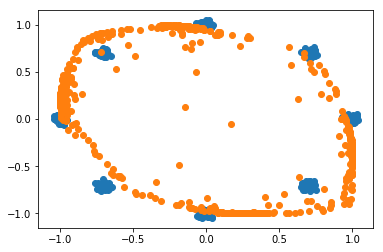

  5%|███▉                                                                          | 500/10000 [02:30<48:21,  3.27it/s]

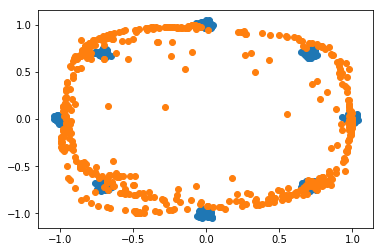

 10%|███████▋                                                                     | 1000/10000 [05:01<51:27,  2.91it/s]

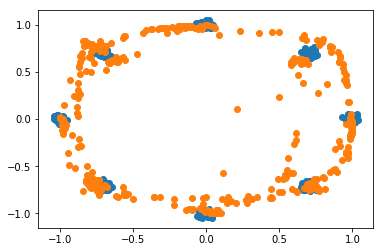

 15%|███████████▌                                                                 | 1500/10000 [07:44<46:49,  3.03it/s]

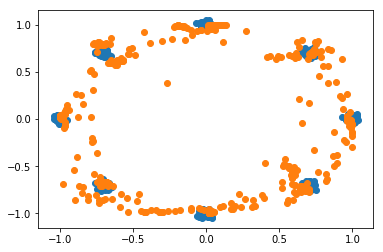

 20%|███████████████▍                                                             | 2000/10000 [10:22<41:59,  3.17it/s]

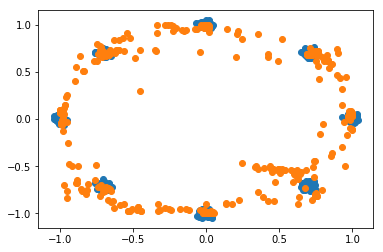

 25%|███████████████████▎                                                         | 2500/10000 [12:56<40:10,  3.11it/s]

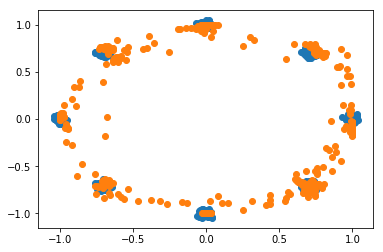

 30%|███████████████████████                                                      | 3000/10000 [15:29<33:37,  3.47it/s]

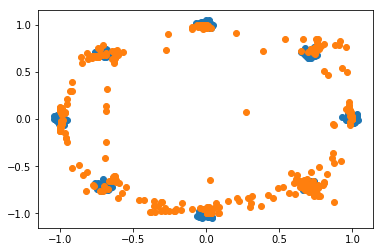

 35%|██████████████████████████▉                                                  | 3500/10000 [18:07<33:23,  3.24it/s]

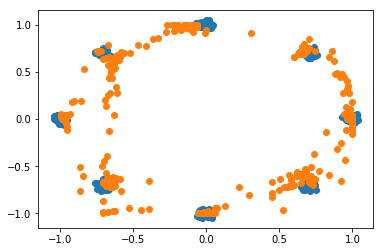

 40%|██████████████████████████████▊                                              | 4000/10000 [20:44<31:00,  3.22it/s]

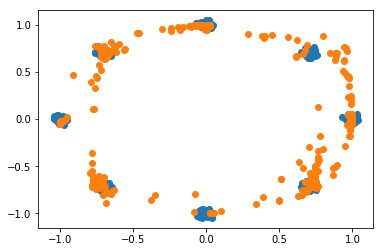

 45%|██████████████████████████████████▋                                          | 4500/10000 [23:24<25:26,  3.60it/s]

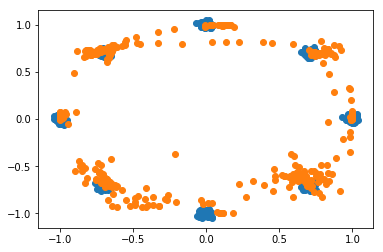

 50%|██████████████████████████████████████▌                                      | 5000/10000 [26:01<27:52,  2.99it/s]

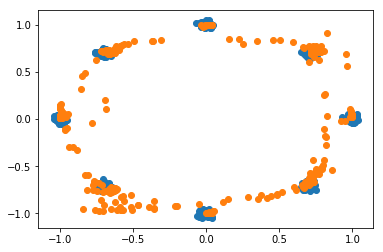

 55%|██████████████████████████████████████████▎                                  | 5500/10000 [28:46<22:33,  3.33it/s]

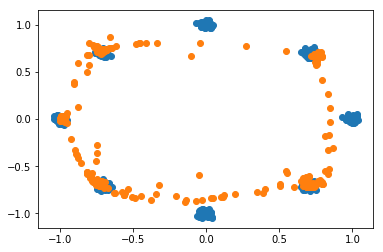

 60%|██████████████████████████████████████████████▏                              | 6000/10000 [31:26<21:37,  3.08it/s]

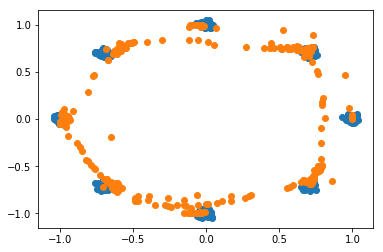

 65%|██████████████████████████████████████████████████                           | 6500/10000 [34:01<15:47,  3.69it/s]

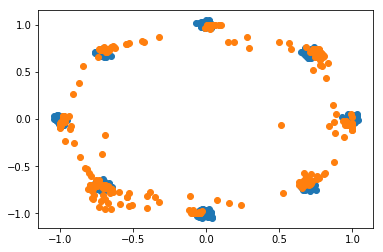

 70%|█████████████████████████████████████████████████████▉                       | 7000/10000 [36:38<17:23,  2.87it/s]

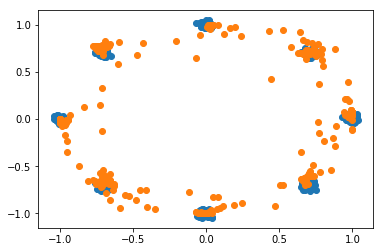

 75%|█████████████████████████████████████████████████████████▊                   | 7500/10000 [39:23<13:13,  3.15it/s]

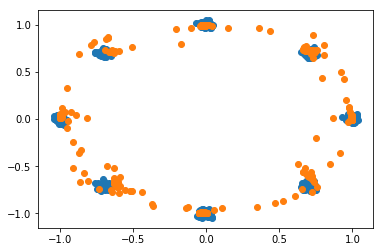

 80%|█████████████████████████████████████████████████████████████▌               | 8000/10000 [42:07<12:02,  2.77it/s]

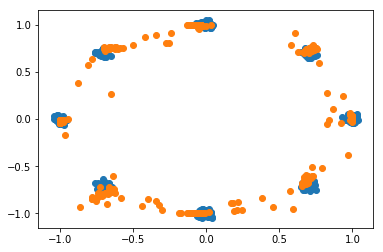

 85%|█████████████████████████████████████████████████████████████████▍           | 8500/10000 [44:56<08:46,  2.85it/s]

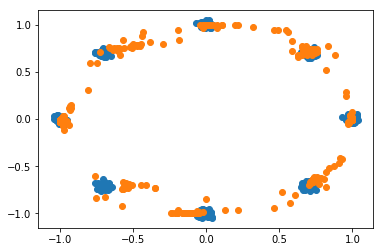

 90%|█████████████████████████████████████████████████████████████████████▎       | 9000/10000 [47:39<05:16,  3.16it/s]

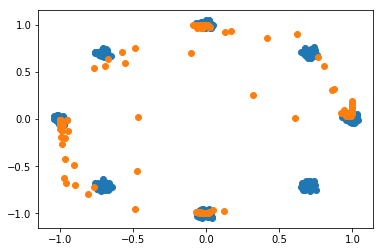

 95%|█████████████████████████████████████████████████████████████████████████▏   | 9500/10000 [50:19<02:35,  3.21it/s]

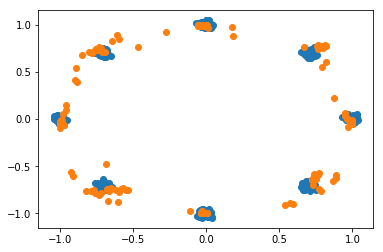

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [53:03<00:00,  2.77it/s]


In [13]:
meta_matrix = np.zeros((1,1))
meta_matrix = augment_calculate_missing_entries(meta_matrix, generator_list, discriminator_list)
# Start Training Loop
for epoch in tqdm(range(10000)): #PARAMS['epochs'])):
    if epoch > 4:
        G = generator_list[epoch %5]
        D = discriminator_list[epoch%5]
    else:
        G = Generator()
        D = Discriminator()
    if cuda:
        G.cuda()
        D.cuda()
    for d in train_loader:
        D = discriminator_oracle(d, G, D, g_dist, generator_list, epoch)
    for d in train_loader:
        G = generator_oracle(d, G, D, d_dist, discriminator_list, epoch)
   
    if epoch ==4:
        generator_list[0] = G
    elif epoch >= 5:
        generator_list[epoch % 5] = G
    else:
        generator_list.append(G)
#     discriminator_list[0] = D
    if epoch ==4:
        discriminator_list[0] = D
    elif epoch >= 5:
        discriminator_list[epoch % 5] = D
    else:
        discriminator_list.append(D)
    meta_matrix = augment_calculate_missing_entries(meta_matrix, generator_list, discriminator_list)
    g_dist, d_dist = NE_solver(meta_matrix)
#     print(g_dist)
    g_sample = []
    population = np.arange(0,len(generator_list))
    weights = g_dist
    if epoch % 500 == 0:
        for g in generator_list:
            g_sample.append(g(fixed_z).cpu().detach().numpy())
        g_gen_img = np.ndarray((512,2))
        for i in range(512):
            index = choices(population, weights)
            g_gen_img[i] = g_sample[index[0]][i]
        plt.plot(dataset[:, 0], dataset[:, 1], 'o',label='real data')

        weights = []
        g_gen_img1 = np.ndarray((512,2))
        for i in range(len(generator_list)):
            weights.append(1/len(generator_list))
        for i in range(512):
            index = choices(population, weights)
            g_gen_img1[i] = g_sample[index[0]][i]

    #     plt.plot(g_sample[epoch % 3][:, 0], g_sample[epoch % 3][:, 1], 'o',label='real data')
    #     plt.plot(g_sample[1][:, 0], g_sample[1][:, 1], 'o',label='real data')
    #     if epoch >2:
    #         plt.plot(g_sample[2][:, 0], g_sample[2][:, 1], 'o',label='real data')
        plt.plot(g_gen_img[:, 0], g_gen_img[:, 1], 'o', label='real data')
        plt.show()

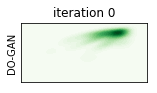

In [14]:
import seaborn as sns
np_samples_ = g_samples
cols = len(np_samples_)
bg_color  = sns.color_palette('Greens', n_colors=256)[0]
plt.figure(figsize=(2*5, 2*(cols/5)+1))
for i, samps in enumerate(np_samples_):
    if i==0:
        ax = plt.subplot((cols/5)+1.5,5,1)  
        plt.ylabel('DO-GAN')  
    else:
        plt.subplot((cols/5)+1.5,5,i+1, sharex=ax, sharey=ax)
    ax2 = sns.kdeplot(samps[:, 0], samps[:, 1], shade=True, cmap='Greens', n_levels=30, clip=[[-3,3]]*2)
    ax2.set_facecolor(bg_color)
    plt.xticks([]); plt.yticks([])
    plt.title('iteration %d'%(i*1000))
plt.gcf().tight_layout()

In [15]:
G = Generator()
G.cuda()
Tensor = torch.FloatTensor
z = Tensor(np.random.normal(0, 1, (512, PARAMS['zdim']))).cuda()
g_samples1 = G(z).cpu().detach().numpy()

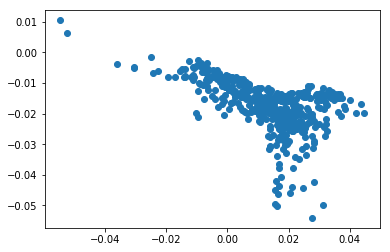

In [16]:
plt.plot(g_samples1[:, 0], g_samples1[:, 1], 'o',label='real data')
plt.show()

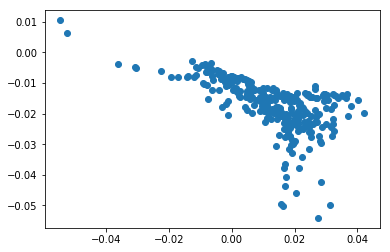

In [17]:
plt.plot(g_samples1[0:300, 0], g_samples1[0:300, 1], 'o',label='real data')
plt.show()

In [18]:
g_samples= []
g_samples.append(g_samples1[0:300,:])

In [19]:
G = Generator()
G.cuda()
Tensor = torch.FloatTensor
z = Tensor(np.random.normal(0, 1, (512, PARAMS['zdim']))).cuda()
g_samples2 = G(z).cpu().detach().numpy()

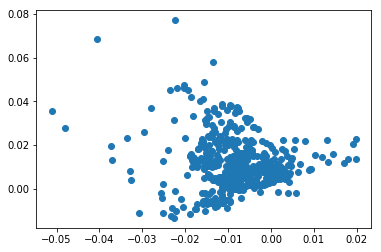

In [20]:
plt.plot(g_samples2[:, 0], g_samples2[:, 1], 'o',label='real data')
plt.show()

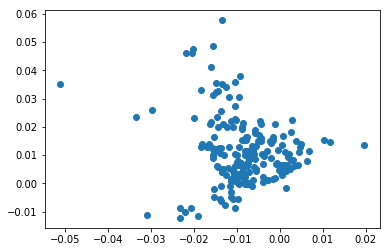

In [21]:
plt.plot(g_samples2[301:512, 0], g_samples2[301:512, 1], 'o',label='real data')
plt.show()

In [22]:
g_samples.append(g_samples2[301:512, :])

In [23]:
g_samples = np.concatenate((, b), axis=0)

SyntaxError: invalid syntax (<ipython-input-23-cc8bc9562292>, line 1)

In [ ]:
plt.plot(g_samples[:, 0], g_samples[:, 1], 'o',label='real data')
plt.show()

In [ ]:
g_samples.squeeze()

In [ ]:
g_samples = np.ndarray((512,2))
for i in range(512):
    if i < 300:
        g_samples[i] = g_samples1[i]
    else:
        g_samples[i] = g_samples2[i]

In [ ]:

plt.plot(g_samples1[:, 0], g_samples1[:, 1], 'x',label='real data')
plt.plot(g_samples2[:, 0], g_samples2[:, 1], 'x',label='real data')
plt.plot(g_samples[:, 0], g_samples[:, 1], 'o',label='real data')
plt.show()

In [ ]:
type(g_samples1)

In [ ]:
g_samples.shape

In [ ]:
g_samples1 = G(z)

In [ ]:
type(g_samples1)

In [ ]:
g_samples1[0]

In [ ]:
type(g)

In [ ]:
g = torch.from_numpy(g_samples).cuda()

In [ ]:
g[0]

In [ ]:
kk =torch.Tensor()

In [ ]:
kk